<a href="https://colab.research.google.com/github/bwsi-hadr/08-graph-optimization-tsp-joegenius98/blob/master/08_Graph_Optimization_Problems_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# Traveling Salesman Problem
The canonical Traveling Salesman Problem is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [0]:
place_name = 'Cambridge, MA, United States'
place_roads = ox.graph_from_place(place_name)


In [0]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

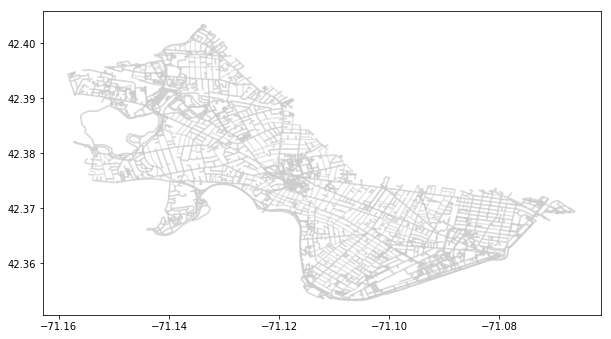

In [26]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [46]:
place_ice_cream = ox.pois_from_place(place_name, amenities=['ice_cream'])
place_ice_cream

,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,brand,brand:wikidata,brand:wikipedia,contact:email,cuisine,delivery,description,drive_through,element_type,email,geometry,name,opening_hours,osmid,outdoor_seating,phone,takeaway,toilets,toilets:access,website,wheelchair,wikidata
317333141,NaN,899,NaN,NaN,Main Street,ice_cream,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,node,NaN,POINT (-71.0994275 42.3635462),Toscanini's,Closed for construction,317333141,NaN,NaN,NaN,yes,customers,https://www.tosci.com/,no,Q7827577
480692709,NaN,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,NaN,NaN,no,NaN,no,node,NaN,POINT (-71.11749090000001 42.3728601),J. P. Licks,NaN,480692709,yes,NaN,yes,NaN,NaN,NaN,NaN,NaN
541316313,NaN,403,02139,NaN,Massachusetts Avenue,ice_cream,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,node,NaN,POINT (-71.1000483 42.3635902),New City Microcreamery,NaN,541316313,NaN,NaN,NaN,NaN,NaN,https://newcitymicrocreamery.com,NaN,NaN
1831393836,Cambridge,1255,02139,MA,Cambridge Street,ice_cream,NaN,NaN,NaN,iceandspice@comcast.net,ice_cream,NaN,NaN,no,node,NaN,POINT (-71.09838259999999 42.3735097),Christina's Homemade Ice Cream,Mo-Su 11:30-22:30,1831393836,NaN,+1-617-492-7021,NaN,NaN,NaN,http://christinasicecream.com/,NaN,NaN
5037446745,Somerville,415,02145,MA,Medford Street,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,contact@tippingcowicecream.com,POINT (-71.09941689999999 42.3914845),Tipping Cow,NaN,5037446745,NaN,+1-617-718-0558,NaN,NaN,NaN,https://www.tippingcowicecream.com,NaN,NaN
5695456136,NaN,36,NaN,NaN,Davis Square,ice_cream,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,node,NaN,POINT (-71.1224698 42.396944),J.P. Licks,Su-Th 11:00-23:00; Fr-Sa 11:00-24:00,5695456136,yes,NaN,yes,NaN,NaN,NaN,NaN,NaN
5916924485,Cambridge,159,02142,MA,First Street,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,NaN,POINT (-71.07816080000001 42.3660456),Toscanini's Ice Cream,Mo-Su 10:00-23:00,5916924485,NaN,+1 (617) 491-5877,NaN,NaN,NaN,https://www.tosci.com/,NaN,NaN
6101491948,NaN,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,NaN,POINT (-71.11979700000001 42.3831991),Honeycomb Creamery,"Su-Th 12:00-22:00; Fr,Sa 12:00-23:00",6101491948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6113522434,Somerville,626,NaN,MA,Somerville Avenue,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,NaN,POINT (-71.1107985 42.3838875),Forge Ice Cream Bar,Mo-Fr 14:00-21:00; Sa-Su 12:00-21:00,6113522434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6114610858,Cambridge,1668,02138,MA,Massachusetts Avenue,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,Frozen yogurt,NaN,node,NaN,POINT (-71.1199089 42.3820185),Berryline,Mo-Su 12:00-23:00,6114610858,NaN,+1 617 492 3555,NaN,NaN,NaN,http://www.berryline.com/,NaN,NaN


In [0]:
place_ice_cream['geometry'] = place_ice_cream.centroid 
# same thing as ...['geometry'] = ...['geometry'].centroid

In [58]:
ice_cream_nodes = ox.get_nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes
# this method finds all the network nodes nearby to each amenity point 

array([  61321277,   61324477, 5035889430,   61324518,   61170539,
         71937408,   61327141,   61322186, 5458392905, 2559968283,
         61321986])

In [60]:
place_roads.nodes[61321277]

{'highway': 'traffic_signals',
 'osmid': 61321277,
 'x': -71.0994207,
 'y': 42.3634171}

## Exercise
Plot the locations of the ice cream shops on the map of the roads

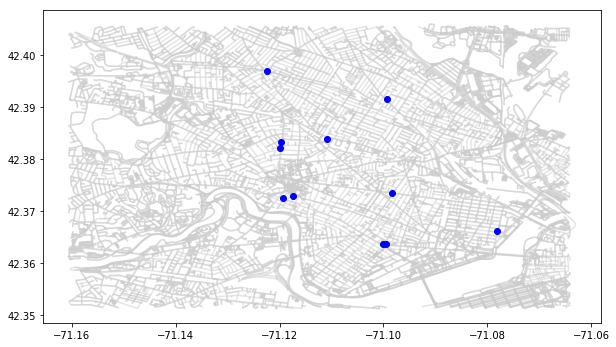

In [57]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)
place_ice_cream.plot(ax = ax, color = 'blue', zorder = 10) # z-axis (so that points get layered on top of graph)


In [0]:
cambridge_bounds = Polygon.from_bounds(*place_roads_edges.total_bounds)

In [0]:
cambridge_bounds = cambridge_bounds.buffer(0.001)

In [55]:
place_roads = ox.graph_from_polygon(cambridge_bounds)
place_roads

In [0]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

## Compute shortest path matrix

In [61]:
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
  for idx_j, dest in enumerate(ice_cream_nodes):
    shortest_path_matrix[idx_i, idx_j] = nx.shortest_path_length(place_roads, orig, dest, weight='length')
shortest_path_matrix

array([[   0.   , 1835.064,   38.79 , 1299.504, 3490.536, 4780.867,
        2069.827, 3237.888, 3131.259, 2966.392, 2102.05 ],
       [1934.426,    0.   , 1895.636, 1950.246, 2943.719, 3148.078,
        3899.601, 1402.824, 1862.674, 1131.328,  266.986],
       [  38.79 , 1796.274,    0.   , 1260.714, 3451.746, 4742.077,
        2108.617, 3199.098, 3092.469, 2927.602, 2063.26 ],
       [1299.504, 1833.441, 1260.714,    0.   , 2307.008, 3626.039,
        2239.096, 2442.516, 1976.431, 2257.92 , 2047.607],
       [3570.099, 3261.111, 3531.309, 2386.571,    0.   , 2475.398,
        3649.135, 2654.34 , 1678.987, 2654.472, 3326.438],
       [4644.464, 3071.612, 4605.674, 3489.636, 2341.163,    0.   ,
        5563.08 , 1685.751, 1836.388, 1859.764, 3039.688],
       [2044.176, 3673.676, 2082.966, 2260.046, 3713.294, 5609.772,
           0.   , 4557.886, 3994.122, 4373.29 , 3940.662],
       [3294.099, 1429.237, 3255.309, 2551.636, 2821.509, 2037.949,
        4646.056,    0.   , 1361.149,  174.

In [0]:
ice_cream_graph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [63]:
# new graph indexes from 0
ice_cream_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

In [80]:
len(ice_cream_graph.nodes)

11

In [69]:
# rename node labels using original labels
ice_cream_graph = nx.relabel_nodes(ice_cream_graph,{k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)})
ice_cream_graph.nodes

NodeView((61321277, 61324477, 5035889430, 61324518, 61170539, 71937408, 61327141, 61322186, 5458392905, 2559968283, 61321986))

In [0]:
nx.draw_networkx_edges(ice_cream_graph, pos = nx.kamada_kawai_layout(ice_cream_graph))

In [74]:
for edge in ice_cream_graph.edges(61321277):
  weird_struct = ice_cream_graph.get_edge_data(*edge)
  print(edge, weird_struct[0]['weight'])

(61321277, 61324477) 1835.064
(61321277, 5035889430) 38.790000000000006
(61321277, 61324518) 1299.5040000000001
(61321277, 61170539) 3490.536
(61321277, 71937408) 4780.867000000001
(61321277, 61327141) 2069.827
(61321277, 61322186) 3237.888
(61321277, 5458392905) 3131.258999999999
(61321277, 2559968283) 2966.392
(61321277, 61321986) 2102.05


## Exercise
Find the best TSP path you can

In [0]:
curr_node = 61321277 # start at a point for the Travel Salesmen Problem
list_visited = [curr_node] # keep track of visited nodes to prevent going back and forth
curr_shortest_w, curr_shortest_nbr = float('inf'), None # variables to keep track of the shortest univisted node 

dist_traveled = 0

needed_len = len(ice_cream_graph.nodes)
while len(list_visited) < needed_len:
  for edge in ice_cream_graph.edges(curr_node): 
    curr_nbr = edge[1]
    if curr_nbr not in set(list_visited):
      test = ice_cream_graph.get_edge_data(*edge)[0]['weight']
      if test < curr_shortest_w:
        curr_shortest_w = test
        dist_traveled += test
        curr_shortest_nbr = curr_nbr
        
  list_visited += [curr_shortest_nbr]  
  curr_node = curr_shortest_nbr

  if len(list_visited) != needed_len:
    curr_shortest_w, curr_shortest_nbr = float('inf'), None

origin = list_visited[0]
dist_traveled += ice_cream_graph.get_edge_data(curr_shortest_nbr, origin)[0]['weight']
list_visited += [origin]




In [143]:
'''5035889430
61324518
61324477
61321986
2559968283
61322186
5458392905
61170539
71937408
61327141'''
print(" ".join([str(element) for element in list_visited]))
print(f'The total distance traveled is {dist_traveled}')


61321277 5035889430 61324518 61324477 61321986 2559968283 61322186 5458392905 61170539 71937408 61327141 61321277
The total distance traveled is 41790.64600000001


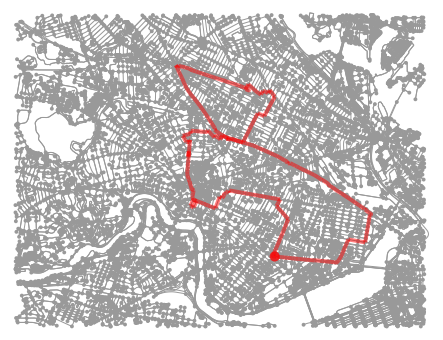

(<Figure size 770.101x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56c1d1c438>)

In [148]:
# print(list_visited)
# print(nx.shortest_path(place_roads, source = list_visited[2], target = list_visited[3]))
def process_path(path):
  to_ret = []
  for sublist in path:
    for element in sublist:
      if len(to_ret) == 0 or element != to_ret[-1]:
        to_ret.append(element)
  return to_ret

path = [nx.shortest_path(place_roads, source = list_visited[i], target = list_visited[i + 1], weight = 'length') for \
                                           i in range(len(list_visited) - 1)]
path = process_path(path)
ox.plot_graph_route(place_roads, route = path)


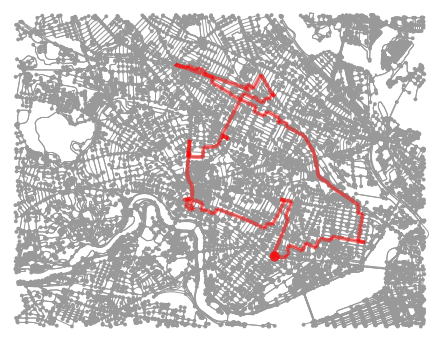

(<Figure size 770.101x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56c87e5a90>)

In [149]:
path = [nx.shortest_path(place_roads, source = list_visited[i], target = list_visited[i + 1]) for \
                                           i in range(len(list_visited) - 1)]
path = process_path(path)
ox.plot_graph_route(place_roads, route = path)